# Imports

In [30]:
import importlib
import functions as f  # Our defined functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

importlib.reload(f)

GRatio = (1 + 5 ** .5) / 2

WIDTH = .5
DASH = (10, 10)


# Solving models

Model verified.
Writing model to file models/SIRS_deaths.json.
File name already exists.


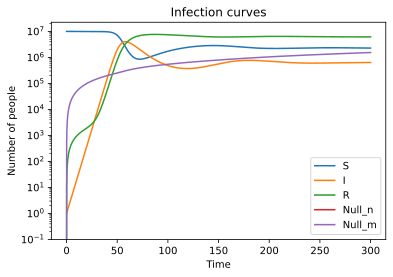

Pop variation: -940350


In [31]:
name = 'SIRS_deaths'
model = f.loadModel(name)
solution, t_span = f.solve(model, (0, 300), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.yscale('log')
plt.ylim(bottom=.1)
plt.show()

print(f"Pop variation: {f.getPopChange(model, solution):+.0f}")


Model verified.
Writing model to file models/SIRS_vars.json.
File name already exists.


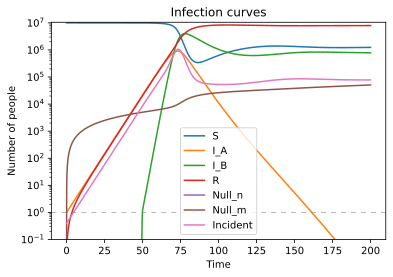

Pop variation: -30912
{'Rt(S,I_A)': 1.9979958959784725, 'Rt(S,I_B)': 0.0}


In [32]:
modelName = 'SIRS_vars'

model = f.loadModel(modelName)
solution, t_span = f.solve(model, (0, 200), 100)

# SIRS_deaths2 = f.mod(SIRS_deaths)
# solution2, t_span2 = f.solve(SIRS_deaths2, (0, 200), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.plot(t_span, f.infCurve(model, solution, t_span), label='Incident')
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.axhline(y=1, linestyle='--', color='grey', linewidth=WIDTH, dashes=DASH)
plt.yscale('log')
plt.show()

popChange = f.getPopChange(model, solution)
print(f"Pop variation: {popChange:.0f}")

f.mod(model)

model, modelMod, _, r0 = f.computeR0(
            modelName, (0, 300), printInit=False, printWarnings=False,
            autoInfections=True, scaledInfs=False, printText=False)

print(r0)

# $\mathcal{R}_t$ curves


Scaled: False, Auto: True
Time difference is not relevant, no intersection between rt and 1.


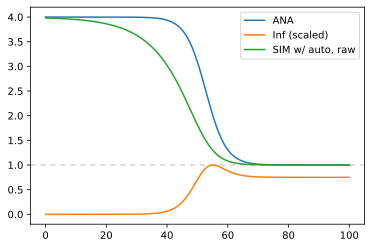

In [33]:
rtCurves, newInfs, rt_ANA = f.compare("SIS", (0, 100), R0=4)
plt.show()


Scaled: False, Auto: True
Time difference: 0.46999999999999886


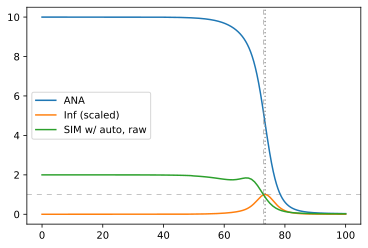

In [35]:
rtCurves = \
    f.compare("SIR_vars", (0, 100), 1, R0=10,
                   plotANA = True)
plt.show()

In [ ]:
rtCurves = \
    f.compare("SIR_test", (0, 100), 1, R0=5)
plt.show()

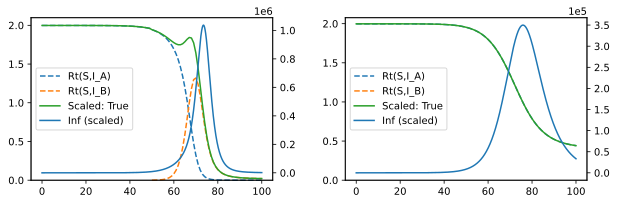

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

model, newModel, solution, t_span, values = f.computeRt(
    'SIR_vars', (0, 100), sub_rt=1, autoInfections=True,
    scaledInfs=True, write=False, printText=False,
    printInit=False, printWarnings=False)

rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])

    idx = np.where(rt_rtNode > 0)
    if len(f.getRtNodes(f.mod(model, False, False))) > 1:
        ax1.plot(rt_times[idx], rt_rtNode[idx], label=rtNode, linestyle='--')
    rt += rt_rtNode


idx = np.where(rt > 0)
ax1.plot(rt_times[idx], rt[idx], label=f'Scaled: {True}')

ax1.set_ylim(bottom=0)

ax3 = ax1.twinx()
infsScaled = f.infCurve(model, solution, t_span)
ax3.plot(t_span, infsScaled, label='Inf (scaled)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()

ax1.legend(lines + lines2, labels + labels2, loc='center left')

# -------------------

model, newModel, solution, t_span, values = f.computeRt(
    'SIR_vars_noB', (0, 100), sub_rt=1, autoInfections=True,
    scaledInfs=True, write=False, printText=False,
    printInit=False, printWarnings=False)

rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])

    idx = np.where(rt_rtNode > 0)
    if len(f.getRtNodes(f.mod(model, False, False))) > 1 and len(idx) > 0:
        ax2.plot(rt_times[idx], rt_rtNode[idx], label=rtNode, linestyle='--')
    rt += rt_rtNode


idx = np.where(rt > 0)
ax2.plot(rt_times[idx], rt[idx], label=f'Scaled: {True}')

ax2.set_ylim(bottom=0)

ax4 = ax2.twinx()
infsScaled = f.infCurve(model, solution, t_span)
ax4.plot(t_span, infsScaled, label='Inf (scaled)')

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc='center left')

ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


plt.subplots_adjust(wspace=.3)

plt.show()


Model verified.
Writing model to file models/SIR_vars.json.
File name already exists.


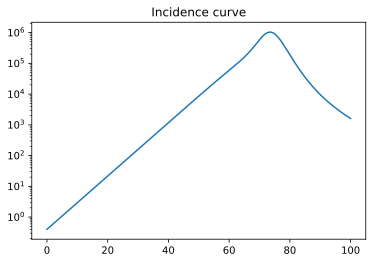

In [37]:
model = f.loadModel('SIR_vars')

solution, t_span = f.solve(model, (0, 100), 100)

infsScaled = f.infCurve(model, solution, t_span)
plt.plot(t_span, infsScaled, label='Infections')
plt.title('Incidence curve')

plt.yscale('log')

plt.show()

Overwriting file.
{'Rt(S,I_A)': 1.9979957793163483, 'Rt(S,I_B)': 0.0}


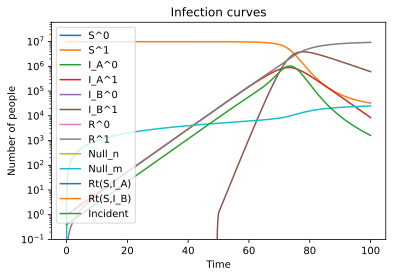

In [39]:
importlib.reload(f)

model, model_mod, initialConds, R0 = f.computeR0(
    "SIR_vars", write=True, overWrite=True, whereToAdd='contact',
    printInit=False, printText=False)

print(R0)

newModel = f.mod(model, False, False)
solution, t_span = f.solve(newModel, (0, 100), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(newModel))
plt.plot(t_span, f.infCurve(newModel, solution, t_span), label='Incident')
plt.yscale('log')
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.show()


In [40]:
# Intégration symbolique

# import sympy as sym
# from sympy import exp
# tInt = sym.symbols('tInt')
# func = 'exp(-tInt)'

# sym.init_printing()

# sym.print_latex(sym.integrate(func, tInt))
# sym.print_latex(eval(func))
# sym.print_latex(sym.diff(func))

In [47]:
importlib.reload(f)

name = 'SIR_test'
measures = {
    'layerDistance': '2cm',
    'nodeDistance': '2cm',
    'varDistance': '.5cm',
    'nullDistance': '.8cm',
    'baseAngle': 10,
    'contactPositions': ("2/5", "3/5")
}

# f.printModel(f.loadModel(name, True, False))

f.createLaTeX(f.loadModel(name, True, False), **measures)

f.createLaTeX(f.mod(f.loadModel(name, True, False),
                    overWrite=True), **measures)


Overwriting file.
Overwriting file.
Overwriting file.
